In [143]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

import joblib

In [144]:
open('ObesityDataSet_raw_and_data_sinthetic.csv')

<_io.TextIOWrapper name='ObesityDataSet_raw_and_data_sinthetic.csv' mode='r' encoding='cp936'>

In [145]:
obesity = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
print(obesity.shape)
obesity.head(2)

(2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight


In [146]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(obesity)

Gender 
 ['Female' 'Male'] 

Age 
 [14.      15.      16.      ... 55.24625 56.      61.     ] 

Height 
 [1.45     1.456346 1.48     ... 1.947406 1.975663 1.98    ] 

Weight 
 [ 39.        39.101805  39.371523 ... 160.935351 165.057269 173.      ] 

family_history_with_overweight 
 ['no' 'yes'] 

FAVC 
 ['no' 'yes'] 

FCVC 
 [1.       1.003566 1.005578 1.00876  1.031149 1.036159 1.036414 1.052699
 1.053534 1.063449 1.064162 1.067909 1.078529 1.081585 1.0816   1.096455
 1.108663 1.116068 1.118436 1.122127 1.123672 1.123939 1.133844 1.140615
 1.142468 1.164062 1.168856 1.188089 1.202075 1.203754 1.204855 1.206276
 1.212908 1.21498  1.220024 1.261288 1.263216 1.264234 1.270448 1.276858
 1.27785  1.289315 1.303878 1.306844 1.31415  1.317729 1.321028 1.3307
 1.34138  1.344854 1.362441 1.368978 1.369529 1.387489 1.392665 1.397468
 1.412566 1.428289 1.431346 1.443674 1.450218 1.451337 1.452524 1.455602
 1.457758 1.469384 1.475906 1.482722 1.4925   1.492834 1.517912 1.518966
 1.521604 1.52200

In [147]:
def get_snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [148]:
snapshot = get_snapshot(obesity)
snapshot

,n_unique,dtype,n_missing,pct_missing
Gender,2,object,0,0.0
Age,1402,float64,0,0.0
Height,1574,float64,0,0.0
Weight,1525,float64,0,0.0
family_history_with_overweight,2,object,0,0.0
FAVC,2,object,0,0.0
FCVC,810,float64,0,0.0
NCP,635,float64,0,0.0
CAEC,4,object,0,0.0
SMOKE,2,object,0,0.0


In [149]:
cate = snapshot[(snapshot['n_unique'] == 2) | (snapshot['n_unique'] == 4) | (snapshot['n_unique'] == 5)].index
num = snapshot.index.drop(cate).drop('NObeyesdad')

In [150]:
num

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

In [151]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 60)
    plt.grid()
    plt.title(col)
    plt.show()

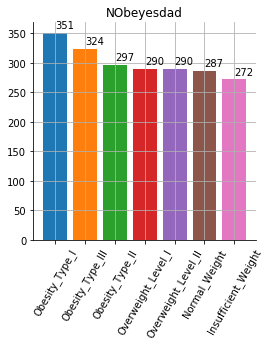

In [152]:
plot_single_categorical(obesity, 'NObeyesdad')

In [153]:
snapshot['n_unique'].sort_values().unique()

array([   2,    4,    5,    7,  635,  810, 1129, 1190, 1268, 1402, 1525,
       1574], dtype=int64)

In [154]:
snapshot[(snapshot['n_unique'] == 4) | (snapshot['n_unique'] == 5) | (snapshot['n_unique'] == 7)]

,n_unique,dtype,n_missing,pct_missing
CAEC,4,object,0,0.0
CALC,4,object,0,0.0
MTRANS,5,object,0,0.0
NObeyesdad,7,object,0,0.0


In [155]:
obesity_4_cols = obesity[['CAEC', 'CALC', 'MTRANS', 'NObeyesdad']]

In [156]:
obesity_dummi = pd.get_dummies(data = obesity, columns = ['MTRANS', 'NObeyesdad'], dtype = int)

In [157]:
feat_bina = snapshot[snapshot['n_unique'] == 2].index

In [158]:
enc = OrdinalEncoder(dtype = int)
obesity_bina = pd.DataFrame(enc.fit_transform(obesity[feat_bina]), columns = feat_bina)
obesity_ordi = pd.DataFrame(enc.fit_transform(obesity[['CAEC', 'CALC']]), columns = ['CAEC', 'CALC'])

In [159]:
obesity_dummi.drop(feat_bina, axis = 1, inplace = True)
obesity_dummi.drop(['CAEC', 'CALC'], axis = 1, inplace = True)

In [160]:
obesity_transformed = obesity_bina.join(obesity_ordi).join(obesity_dummi)

In [161]:
tar_dummi = []
for col in obesity_transformed.columns:
    if col.startswith('NObeyesdad'):
        tar_dummi.append(col)

In [162]:
obesity_transformed['NObeyesdad_Obesity_Type_I'] = obesity_transformed['NObeyesdad_Obesity_Type_I'].astype(str)

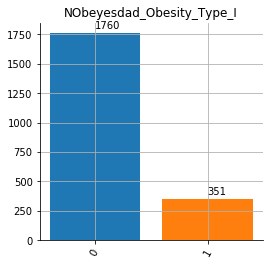

In [163]:
plot_single_categorical(obesity_transformed, 'NObeyesdad_Obesity_Type_I')

In [165]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()

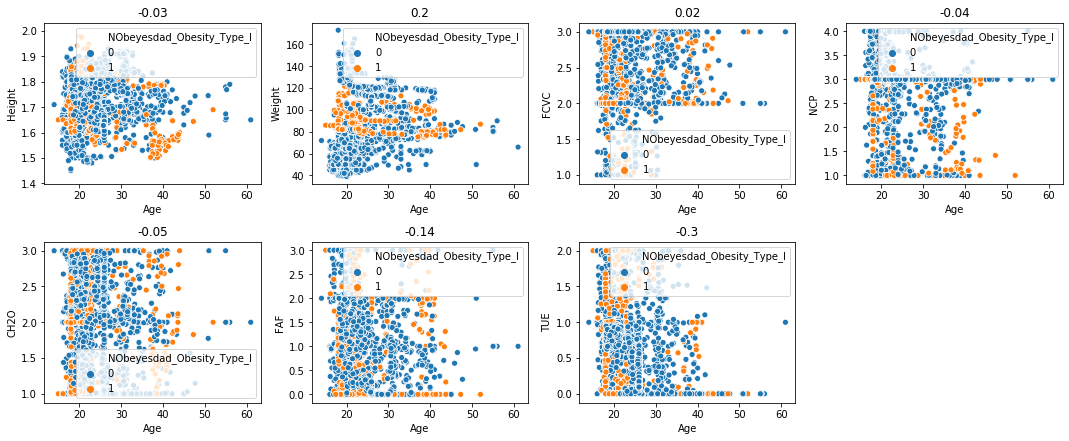

In [166]:
scatter_fea_corr_classif_targ(obesity_transformed, num.tolist(), 'NObeyesdad_Obesity_Type_I')

In [167]:
obesity_transformed['NObeyesdad_Obesity_Type_I'] = obesity_transformed['NObeyesdad_Obesity_Type_I'].astype(int)

In [168]:
features = obesity_transformed.columns.drop(tar_dummi)

In [181]:
len(features)

20

In [169]:
def feat_significance(X, y, n_feat_data_type, num):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in num:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [174]:
feat_score = feat_significance(obesity_transformed[features], obesity_transformed['NObeyesdad_Obesity_Type_I'], 2, num)
feat_score

,score
Weight,0.200356
Age,0.043283
NCP,0.035759
FCVC,0.033463
CALC,0.020945
Height,0.020236
family_history_with_overweight,0.018817
CAEC,0.014397
MTRANS_Automobile,0.013758
MTRANS_Public_Transportation,0.008570


In [177]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [178]:
get_mean_std(obesity_transformed[features])

,mean,std
Gender,0.505921,0.500083
family_history_with_overweight,0.817622,0.386247
FAVC,0.883941,0.320371
SMOKE,0.020843,0.142893
SCC,0.045476,0.208395
CAEC,1.859308,0.468543
CALC,2.268593,0.515498
Age,24.312600,6.345968
Height,1.701677,0.093305
Weight,86.586058,26.191172


In [179]:
X_scaled = pd.DataFrame(scale(obesity_transformed[features]), columns = features)
y = obesity_transformed['NObeyesdad_Obesity_Type_I']

In [171]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)

In [172]:
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [173]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

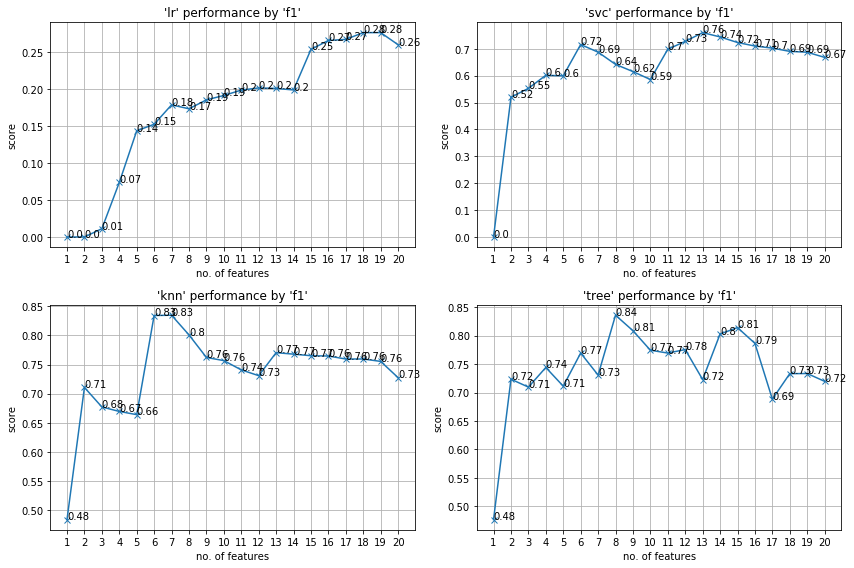

In [180]:
num_feat_multi_alg(alg_dict, feat_score.index, X_scaled[feat_score.index], y, 'f1')

In [194]:
feat_knn = []
for index in [0, 1, 5]:
    feat_knn.append(feat_score.index[index])
    
feat_knn

['Weight', 'Age', 'Height']

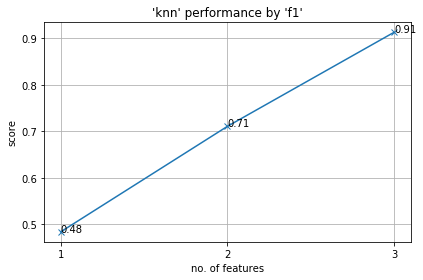

In [195]:
num_feat_multi_alg({knn: 'knn'}, feat_knn, X_scaled[feat_knn], y, 'f1')

In [196]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 10, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

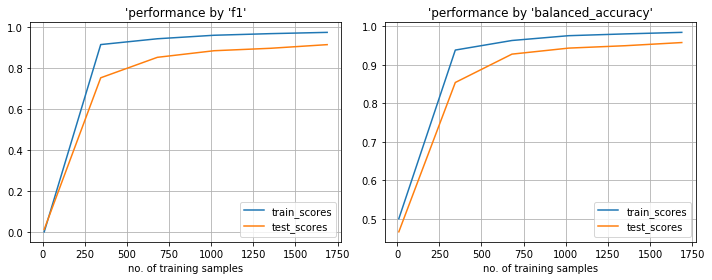

In [197]:
two_metric_graph(knn, X_scaled[feat_knn], y)

In [202]:
knn.fit(X_scaled[feat_knn], y)
joblib.dump(knn, 'knn.joblib')

['knn.joblib']